In [143]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib 
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import map_coordinates
from Functions import generate_grid_unit, save_img, save_flow, transform_unit_flow_to_flow, load_4D
from miccai2020_model_stage import Miccai2020_LDR_laplacian_unit_disp_add_lvl1, \
    Miccai2020_LDR_laplacian_unit_disp_add_lvl2, Miccai2020_LDR_laplacian_unit_disp_add_lvl3, SpatialTransform_unit
from torch.utils.data import DataLoader


In [144]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import matplotlib.pyplot as plt
import monai
import torch


def preview_image(image_array, normalize_by="volume", cmap=None, figsize=(12, 12), threshold=None, title=""):
    """
    Display three orthogonal slices of the given 3D image.

    image_array is assumed to be of shape (H,W,D)

    If a number is provided for threshold, then pixels for which the value
    is below the threshold will be shown in red
    """
    if normalize_by == "slice":
        vmin = None
        vmax = None
    elif normalize_by == "volume":
        vmin = 0
        vmax = image_array.max().item()
    else:
        raise (ValueError(f"Invalid value '{normalize_by}' given for normalize_by"))

    # half-way slices
    x, y, z = np.array(image_array.shape) // 2
    imgs = (image_array[x, :, :], image_array[:, y, :], image_array[:, :, z])

    fig, axs = plt.subplots(1, 3, figsize=figsize)
#     fig.suptitle(title)
    for ax, im in zip(axs, imgs):
        ax.axis("off")
        ax.imshow(im, origin="lower", vmin=vmin, vmax=vmax, cmap=cmap)

        # threshold will be useful when displaying jacobian determinant images;
        # we will want to clearly see where the jacobian determinant is negative
        if threshold is not None:
            red = np.zeros(im.shape + (4,))  # RGBA array
            red[im <= threshold] = [1, 0, 0, 1]
            ax.imshow(red, origin="lower")
    
   
    plt.show()


def plot_2D_vector_field(vector_field, downsampling):
    """Plot a 2D vector field given as a tensor of shape (2,H,W).

    The plot origin will be in the lower left.
    Using "x" and "y" for the rightward and upward directions respectively,
      the vector at location (x,y) in the plot image will have
      vector_field[1,y,x] as its x-component and
      vector_field[0,y,x] as its y-component.
    """
    downsample2D = monai.networks.layers.factories.Pool["AVG", 2](kernel_size=downsampling)
    vf_downsampled = downsample2D(vector_field.unsqueeze(0))[0]
    plt.quiver(
        vf_downsampled[1, :, :],
        vf_downsampled[0, :, :],
        angles="xy",
        scale_units="xy",
        scale=downsampling,
        headwidth=4.0,
    )


def preview_3D_vector_field(vector_field, downsampling=None):
    """
    Display three orthogonal slices of the given 3D vector field.

    vector_field should be a tensor of shape (3,H,W,D)

    Vectors are projected into the viewing plane, so you are only seeing
    their components in the viewing plane.
    """

    if downsampling is None:
        # guess a reasonable downsampling value to make a nice plot
        downsampling = max(1, int(max(vector_field.shape[1:])) >> 5)

    x, y, z = np.array(vector_field.shape[1:]) // 2  # half-way slices
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plot_2D_vector_field(vector_field[[1, 2], x, :, :], downsampling)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plot_2D_vector_field(vector_field[[0, 2], :, y, :], downsampling)
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plot_2D_vector_field(vector_field[[0, 1], :, :, z], downsampling)
    plt.show()


def plot_2D_deformation(vector_field, grid_spacing, **kwargs):
    """
    Interpret vector_field as a displacement vector field defining a deformation,
    and plot an x-y grid warped by this deformation.

    vector_field should be a tensor of shape (2,H,W)
    """
    _, H, W = vector_field.shape
    grid_img = np.zeros((H, W))
    grid_img[np.arange(0, H, grid_spacing), :] = 1
    grid_img[:, np.arange(0, W, grid_spacing)] = 1
    grid_img = torch.tensor(grid_img, dtype=vector_field.dtype).unsqueeze(0)  # adds channel dimension, now (C,H,W)
    warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="zeros")
    grid_img_warped = warp(grid_img.unsqueeze(0), vector_field.unsqueeze(0))[0]
    plt.imshow(grid_img_warped[0], origin="lower", cmap="gist_gray")


def preview_3D_deformation(vector_field, grid_spacing, **kwargs):
    """
    Interpret vector_field as a displacement vector field defining a deformation,
    and plot warped grids along three orthogonal slices.

    vector_field should be a tensor of shape (3,H,W,D)
    kwargs are passed to matplotlib plotting

    Deformations are projected into the viewing plane, so you are only seeing
    their components in the viewing plane.
    """
    x, y, z = np.array(vector_field.shape[1:]) // 2  # half-way slices
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plot_2D_deformation(vector_field[[1, 2], x, :, :], grid_spacing, **kwargs)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plot_2D_deformation(vector_field[[0, 2], :, y, :], grid_spacing, **kwargs)
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plot_2D_deformation(vector_field[[0, 1], :, :, z], grid_spacing, **kwargs)
    plt.show()


def jacobian_determinant(vf):
    """
    Given a displacement vector field vf, compute the jacobian determinant scalar field.

    vf is assumed to be a vector field of shape (3,H,W,D),
    and it is interpreted as the displacement field.
    So it is defining a discretely sampled map from a subset of 3-space into 3-space,
    namely the map that sends point (x,y,z) to the point (x,y,z)+vf[:,x,y,z].
    This function computes a jacobian determinant by taking discrete differences in each spatial direction.

    Returns a numpy array of shape (H-1,W-1,D-1).
    """

    _, H, W, D = vf.shape

    # Compute discrete spatial derivatives
    def diff_and_trim(array, axis):
        return np.diff(array, axis=axis)[:, : (H - 1), : (W - 1), : (D - 1)]

    dx = diff_and_trim(vf, 1)
    dy = diff_and_trim(vf, 2)
    dz = diff_and_trim(vf, 3)

    # Add derivative of identity map
    dx[0] += 1
    dy[1] += 1
    dz[2] += 1

    # Compute determinant at each spatial location
    det = (
        dx[0] * (dy[1] * dz[2] - dz[1] * dy[2])
        - dy[0] * (dx[1] * dz[2] - dz[1] * dx[2])
        + dz[0] * (dx[1] * dy[2] - dy[1] * dx[2])
    )

    return det

#https://github.com/adalca/pystrum/blob/0e7a47e5cc62725dfadc728351b89162defca696/pystrum/pynd/ndutils.py#L111

def ndgrid(*args, **kwargs):
    """
    Disclaimer: This code is taken directly from the scitools package [1]
    Since at the time of writing scitools predominantly requires python 2.7 while we work with 3.5+
    To avoid issues, we copy the quick code here.
    Same as calling ``meshgrid`` with *indexing* = ``'ij'`` (see
    ``meshgrid`` for documentation).
    Ref : https://github.com/adalca/pystrum/blob/0e7a47e5cc62725dfadc728351b89162defca696/pystrum/pynd/ndutils.py#L208
    """
    kwargs['indexing'] = 'ij'
    return np.meshgrid(*args, **kwargs)

def volsize2ndgrid(volsize):
    """
    return the dense nd-grid for the volume with size volsize
    essentially return the ndgrid fpr
    """
    ranges = [np.arange(e) for e in volsize]
    return ndgrid(*ranges)



def flow_jacdet(flow):

    vol_size = flow.shape[:-1]
    grid = np.stack(volsize2ndgrid(vol_size), len(vol_size))  
    J = np.gradient(flow + grid)

    dx = J[0]
    dy = J[1]
    dz = J[2]

    Jdet0 = dx[:,:,:,0] * (dy[:,:,:,1] * dz[:,:,:,2] - dy[:,:,:,2] * dz[:,:,:,1])
    Jdet1 = dx[:,:,:,1] * (dy[:,:,:,0] * dz[:,:,:,2] - dy[:,:,:,2] * dz[:,:,:,0])
    Jdet2 = dx[:,:,:,2] * (dy[:,:,:,0] * dz[:,:,:,1] - dy[:,:,:,1] * dz[:,:,:,0])

    Jdet = Jdet0 - Jdet1 + Jdet2

    return Jdet


def plot_against_epoch_numbers(epoch_and_value_pairs, **kwargs):
    """
    Helper to reduce code duplication when plotting quantities that vary over training epochs

    epoch_and_value_pairs: An array_like consisting of pairs of the form (<epoch number>, <value of thing to plot>)
    kwargs are forwarded to matplotlib.pyplot.plot
    """
    array = np.array(epoch_and_value_pairs)
    plt.plot(array[:, 0], array[:, 1], **kwargs)
    plt.xlabel("epochs")
    


In [145]:
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=3, kernel_type="rectangular", reduction="mean"
)

In [146]:

def image_norm(img):
    max_v = np.max(img)
    min_v = np.min(img)

    norm_img = (img - min_v) / (max_v - min_v)
    return norm_img
class NLST(torch.utils.data.Dataset):
    def __init__(self, root_dir, json_conf='NLST_dataset.json', masked=False, 
                 downsampled=False, train_transform = None, train=True, is_norm=False):
       
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir,'imagesTr')
        self.keypoint_dir = os.path.join(root_dir,'keypointsTr')
        self.masked = masked
        with open(os.path.join(root_dir,json_conf)) as f:
            self.dataset_json = json.load(f)
        self.shape = self.dataset_json['tensorImageShape']['0']
        self.H, self.W, self.D = self.shape
        self.downsampled = downsampled
        self.train = train
        
        self.is_norm = is_norm
        if self.train :
            self.type_data = 'training_paired_images'
        
        else:
            self.type_data = 'registration_val'
        
    def __len__(self):
        
        if self.train:
            return self.dataset_json['numPairedTraining']
        else:
            return len(self.dataset_json['registration_val'])

    def get_shape(self):
        if self.downsampled:
            return [x//2 for x in self.shape]
       
        else:
            return self.shape
    
    def __getitem__(self, idx):
        fix_idx = self.dataset_json[self.type_data][idx]['fixed']
        mov_idx = self.dataset_json[self.type_data][idx]['moving']
        
        fix_path=os.path.join(self.root_dir,fix_idx)        
        mov_path=os.path.join(self.root_dir,mov_idx)            
        

        fixed_img = nib.load(fix_path)
        fixed_affine = fixed_img.affine
        fixed_img = fixed_img.get_fdata()
        
        moving_img = nib.load(mov_path).get_fdata()
        
        fixed_img = np.clip(fixed_img, a_min=-1200, a_max=600)
        moving_img = np.clip(moving_img, a_min=-1200, a_max=600)
        
        if self.is_norm:
            fixed_img = image_norm(fixed_img)
            moving_img = image_norm(moving_img)
        
        fixed_img=torch.from_numpy(fixed_img).float()
        moving_img=torch.from_numpy(moving_img).float()
        
        fixed_mask=torch.from_numpy(nib.load(fix_path.replace('images', 'masks')).get_fdata()).float()
        
        moving_mask=torch.from_numpy(nib.load(mov_path.replace('images', 'masks')).get_fdata()).float()
        fixed_kp =  0
        moving_kp = 0
        if not self.train:
            # fixed_kp=torch.from_numpy(np.genfromtxt(fix_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=','))
            # moving_kp=torch.from_numpy(np.genfromtxt(mov_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=','))
            # fixed_kp=(fixed_kp.flip(-1)/torch.tensor(self.shape))*2-1
            # moving_kp=(moving_kp.flip(-1)/torch.tensor(self.shape))*2-1    
            fixed_kp=np.genfromtxt(fix_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=',')
            moving_kp=np.genfromtxt(mov_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=',')
        
        if self.masked and not self.downsampled:           
            fixed_img = fixed_img * fixed_mask
            moving_img = moving_img * moving_mask
   
        if self.downsampled:
            fixed_img=F.interpolate(fixed_img.view(1,1,self.H,self.W,self.D),size=(self.H//2,self.W//2,self.D//2),mode='trilinear').squeeze()
            moving_img=F.interpolate(moving_img.view(1,1,self.H,self.W,self.D), size=(self.H//2,self.W//2,self.D//2), mode='trilinear').squeeze()
            fixed_mask=F.interpolate(fixed_mask.view(1,1,self.H,self.W,self.D),size=(self.H//2,self.W//2,self.D//2),mode='nearest').squeeze()
            moving_mask=F.interpolate(moving_mask.view(1,1,self.H,self.W,self.D),size=(self.H//2,self.W//2,self.D//2),mode='nearest').squeeze()
            if self.masked:
                fixed_img = fixed_img * fixed_mask
                moving_img = moving_img * moving_mask
            if not self.train:
                fixed_kp=np.genfromtxt(fix_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=',')
                moving_kp=np.genfromtxt(mov_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=',')
  
            
        fixed_img = fixed_img.unsqueeze(0)
        moving_img = moving_img.unsqueeze(0)
        fixed_mask = fixed_mask.unsqueeze(0)
        moving_mask = moving_mask.unsqueeze(0)
                                      
        shape = fixed_img.shape[1:-1]
        
        zeros = torch.zeros((1, *shape, len(shape)))
        
        return { "fixed_name" : fix_idx,
                "moving_name" : mov_idx,
                "fixed_img" : fixed_img, 
                "moving_img" : moving_img, 
                "fixed_mask" : fixed_mask, 
                "moving_mask" : moving_mask,
                "zero_flow_field" : zeros,
                "fixed_affine" : fixed_affine,
                "fixed_kp" : fixed_kp,
                "moving_kp" : moving_kp}

In [147]:
import json


use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

val_dataset = NLST("/home/varsha/data/NLST", 'NLST_dataset_train_test_v1.json',
                            downsampled=True
                            , 
                            masked=False,train=False,
                        is_norm=True)
# overfit_set = torch.utils.data.Subset(NLST_dataset, [2] )

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

val_dataset_orig = NLST("/home/varsha/data/NLST", 'NLST_dataset_train_test_v1.json',
                            downsampled=False
                            , 
                            masked=False,train=False,
                        is_norm=True)


## Load models

In [149]:
start_channel = 7
range_flow = 0.4
# model_path = "/home/varsha/code/LapIRN/full/model_mask_lncc_multi_12.07_1/Stage/LDR_NLST_NCC_unit_disp_add_reg_1_stagelvl3_30000.pth"
model_path = "/home/varsha/code/LapIRN/full/model_mask_ncc_27.07_4/Stage/LDR_NLST_NCC_unit_disp_add_reg_1_stagelvl3_5000.pth"

orig_imgshape = (224, 192, 224)
imgshape = (224//2, 192//2, 224//2)
imgshape_4 = (imgshape[0]//4, imgshape[1]//4, imgshape[2]//4)
imgshape_2 = (imgshape[0]//2, imgshape[1]//2, imgshape[2]//2)

model_lvl1 = Miccai2020_LDR_laplacian_unit_disp_add_lvl1(2, 3, start_channel, is_train=True, imgshape=imgshape_4,
                                           range_flow=range_flow).cuda()
model_lvl2 = Miccai2020_LDR_laplacian_unit_disp_add_lvl2(2, 3, start_channel, is_train=True, imgshape=imgshape_2,
                                      range_flow=range_flow, model_lvl1=model_lvl1).cuda()

model = Miccai2020_LDR_laplacian_unit_disp_add_lvl3(2, 3, start_channel, is_train=False, imgshape=imgshape,
                                      range_flow=range_flow, model_lvl2=model_lvl2).cuda()

transform = SpatialTransform_unit().cuda()

model.load_state_dict(torch.load(model_path))
model.eval()
transform.eval()

grid = generate_grid_unit(orig_imgshape)
grid = torch.from_numpy(np.reshape(grid, (1,) + grid.shape)).cuda().float()


In [150]:
flow_fields = {}

with torch.no_grad():
    for batch_idx, batch in enumerate(val_dataloader):
        print(batch["fixed_name"][0])
        val1 = batch["fixed_name"][0][-16:-12]
        val2 = batch["moving_name"][0][-16:-12]
        input_fixed = batch["fixed_img"].to(device)

        input_moving = batch["moving_img"].to(device)

        fixed_affine = batch["fixed_affine"][0]
        #print(input_moving.shape)
        F_X_Y = model(input_moving.to(device), input_fixed.to(device))
        print(F_X_Y.shape)
#         F_X_Y = F.interpolate(F_X_Y, size=orig_imgshape, mode='trilinear', align_corners=True)
        # F_X_Y = F.interpolate(F_X_Y, scale_factor=2, mode='trilinear', align_corners=True) #1. upsample
        print(F_X_Y.shape)

        # X = F.interpolate(input_moving,scale_factor=2, mode='trilinear')
        # print(X.shape)
        # print(grid.shape)
#         X_Y = transform(input_moving, F_X_Y.permute(0, 2, 3, 4, 1), grid).data.cpu().numpy()[0, 0, :, :, :] #warped img

        #2. unnorm and flip
        F_X_Y_xyz = torch.zeros(F_X_Y.shape, dtype=F_X_Y.dtype, device=F_X_Y.device)
        _, _, x, y, z = F_X_Y.shape
        F_X_Y_xyz[0, 0] = F_X_Y[0, 2] * (x - 1) / 2
        F_X_Y_xyz[0, 1] = F_X_Y[0, 1] * (y - 1) / 2
        F_X_Y_xyz[0, 2] = F_X_Y[0, 0] * (z - 1) / 2

        # F_X_Y_clone = F_X_Y.clone()
#         F_X_Y_cpu = F_X_Y_xyz.data.cpu().numpy()[0, :, :, :, :].transpose(1, 2, 3, 0)
        flow_fields[val1] = F_X_Y_xyz

./imagesTr/NLST_0007_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0017_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0027_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0037_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0047_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0057_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0067_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0077_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0087_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0097_0000.nii.gz
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])


In [151]:
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")


moving image:


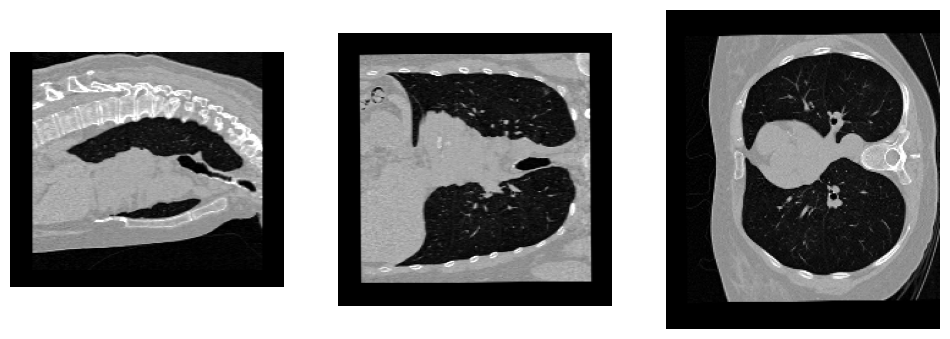

target image:


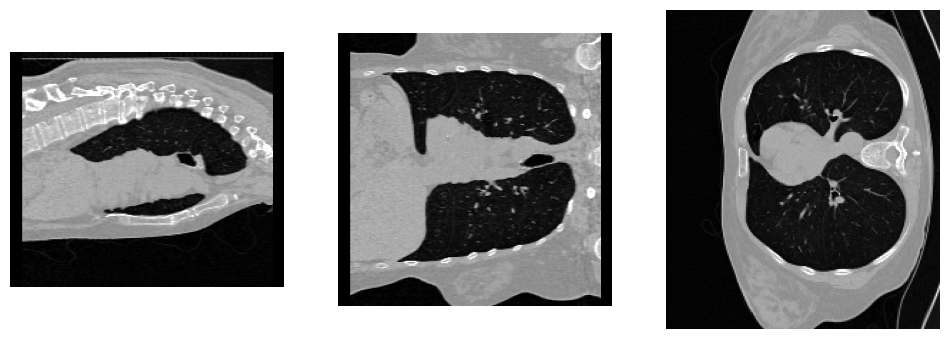

warped moving image:


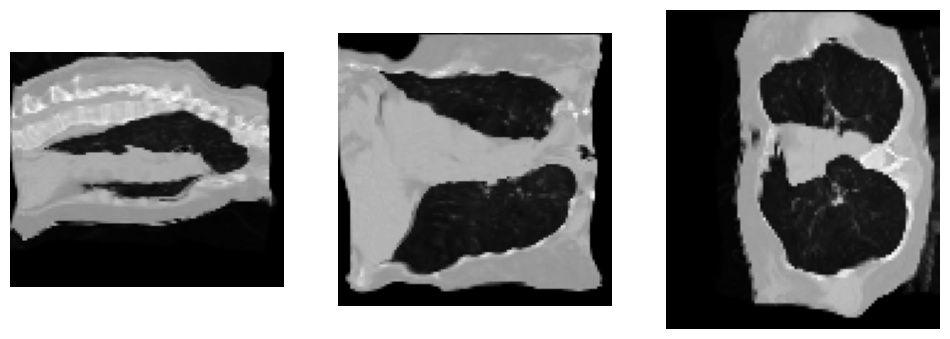

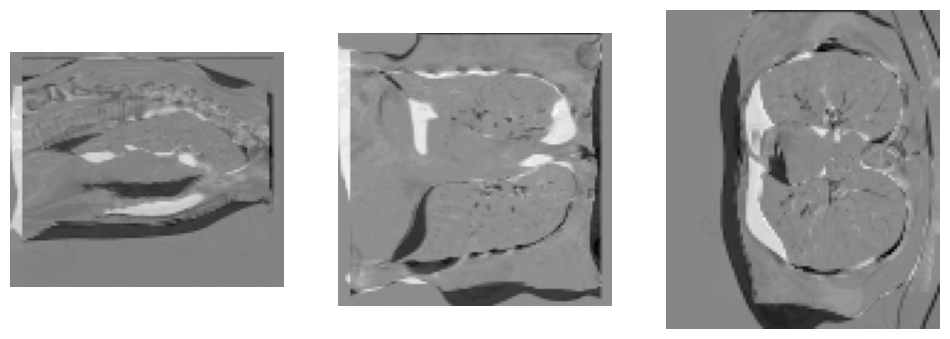

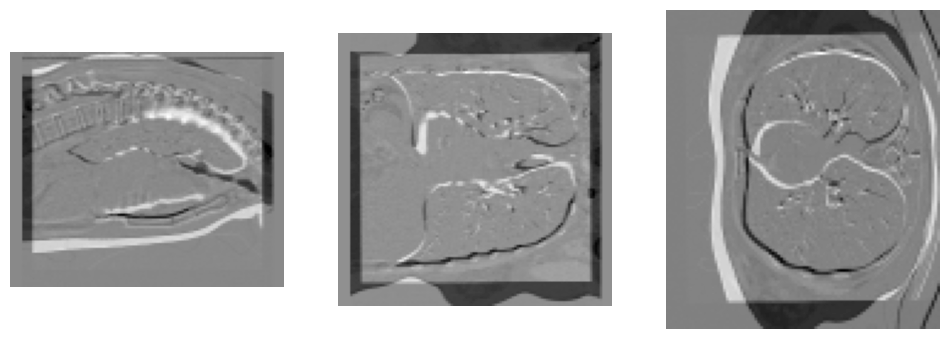

deformation vector field, projected into viewing planes:


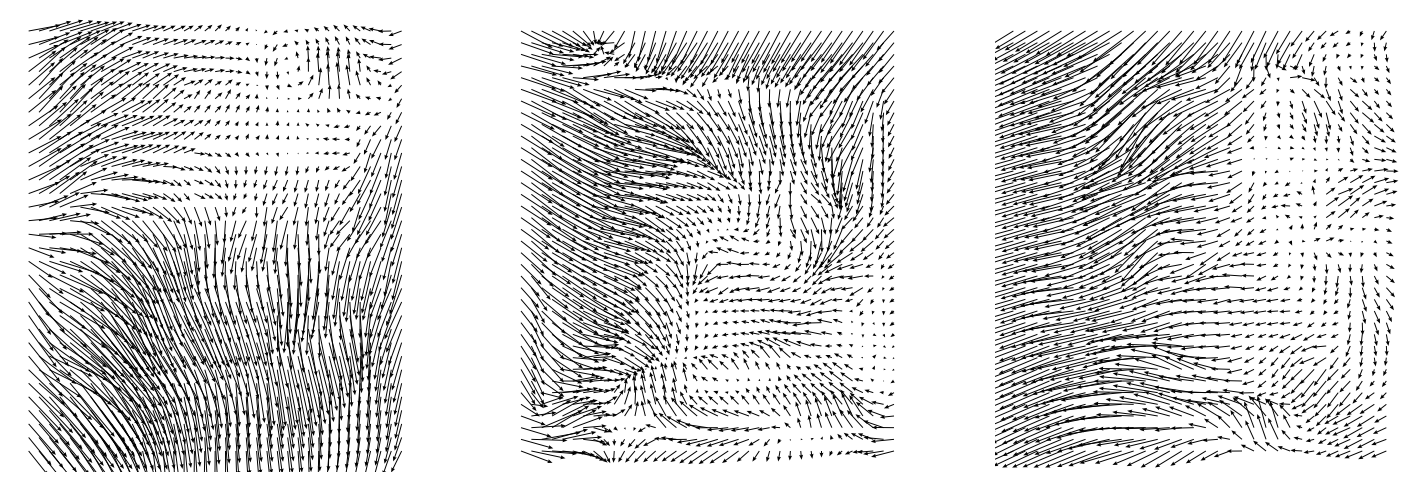

deformation applied to a grid, projected into viewing planes:


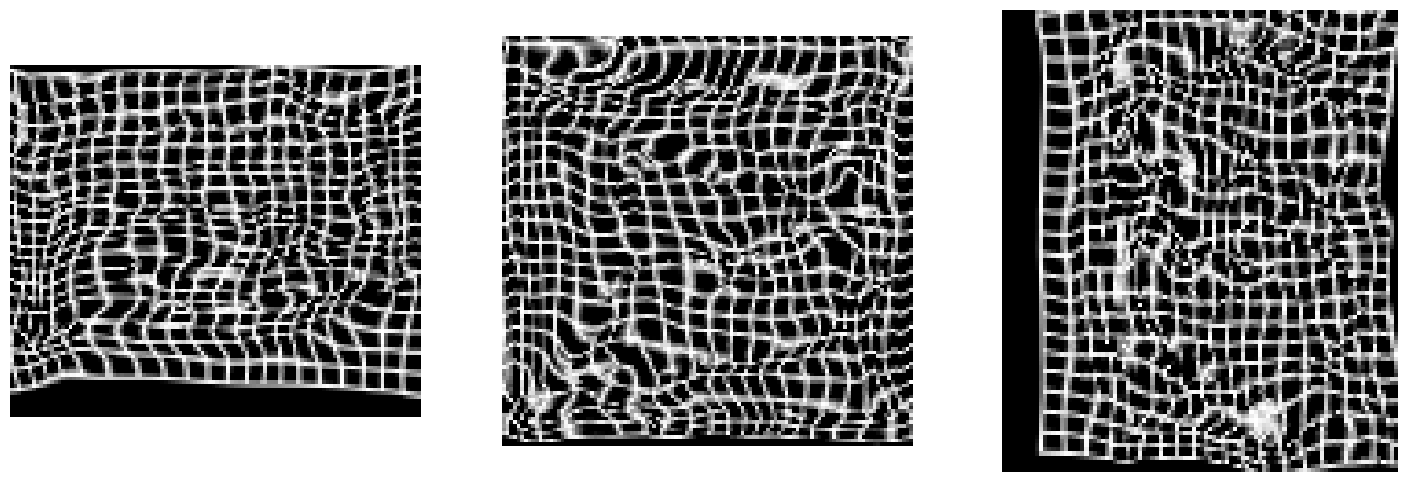

jacobian determinant:


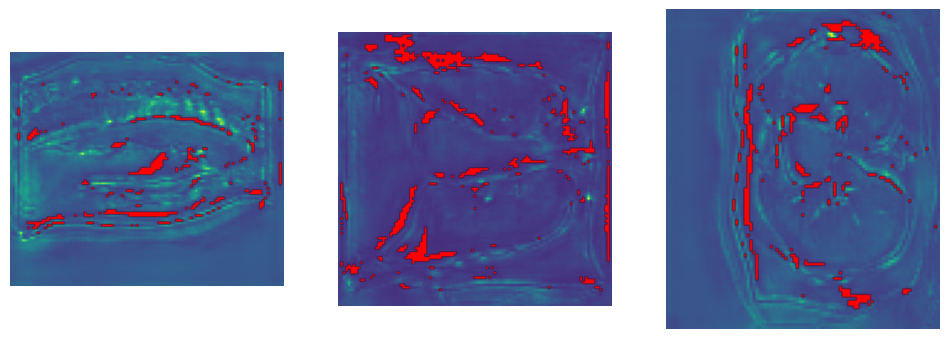

Similarity loss: -0.13686002790927887
number of folds: 44369


In [152]:
example_warped_image = warp(val_dataset[9]["moving_img"].unsqueeze(0).cuda(), flow_fields['0097'])  # moving image  # warping

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(val_dataset_orig[9]["moving_img"][0], normalize_by="slice", cmap="gray")
print("target image:")
preview_image(val_dataset_orig[9]["fixed_img"][0], normalize_by="slice", cmap="gray")
print("warped moving image:")
preview_image(example_warped_image[0, 0].cpu(), normalize_by="slice", cmap="gray")

preview_image(example_warped_image[0, 0].cpu() - val_dataset[9]["fixed_img"].unsqueeze(0)[0, 0], normalize_by="slice", cmap="gray")

preview_image(val_dataset[9]["moving_img"].unsqueeze(0)[0, 0] - val_dataset[9]["fixed_img"].unsqueeze(0)[0, 0], normalize_by="slice", cmap="gray")


print("deformation vector field, projected into viewing planes:")
preview_3D_vector_field( flow_fields['0097'].cpu().detach()[0])
print("deformation applied to a grid, projected into viewing planes:")
preview_3D_deformation( flow_fields['0097'].cpu().detach()[0], 5, linewidth=1, color="darkblue")
print("jacobian determinant:")
det = jacobian_determinant( flow_fields['0097'].cpu().detach()[0])
preview_image(det, normalize_by="slice", threshold=0)
loss = lncc_loss(example_warped_image.cpu(), val_dataset[9]["fixed_img"].unsqueeze(0)).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

In [117]:
def compute_dice(fixed,moving,moving_warped,labels):
    dice = []
    for i in labels:
        if ((fixed==i).sum()==0) or ((moving==i).sum()==0):
            dice.append(np.NAN)
        else:
            dice.append(compute_dice_coefficient((fixed==i), (moving_warped==i)))
    mean_dice = np.nanmean(dice)
    return mean_dice, dice

def compute_dice_coefficient(mask_gt, mask_pred):
    """Computes soerensen-dice coefficient.

    compute the soerensen-dice coefficient between the ground truth mask `mask_gt`
    and the predicted mask `mask_pred`.

    Args:
    mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
    mask_pred: 3-dim Numpy array of type bool. The predicted mask.

    Returns:
    the dice coeffcient as float. If both masks are empty, the result is NaN.
    """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    if volume_sum == 0:
        return 0
    volume_intersect = (mask_gt & mask_pred).sum()
    return 2*volume_intersect / volume_sum

In [118]:
fixed_seg = val_dataset[9]["fixed_mask"][0]

moving_seg = val_dataset[9]["moving_mask"][0]

D,H,W = fixed_seg.shape
identity = np.meshgrid(np.arange(D), np.arange(H), np.arange(W), indexing='ij')
disp_field = flow_fields['0097'][0].permute(1,2,3,0).cpu().numpy()

labels = [1]
warped_seg = map_coordinates(moving_seg.squeeze(0).cpu(), identity + disp_field.transpose(3,0,1,2), order=0)

dice = compute_dice(fixed_seg,moving_seg,warped_seg,labels)
print(dice)

(0.90377355, [tensor(0.9038)])


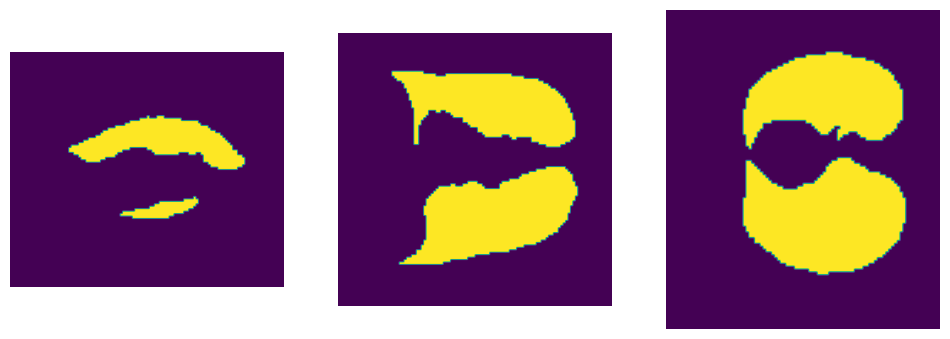

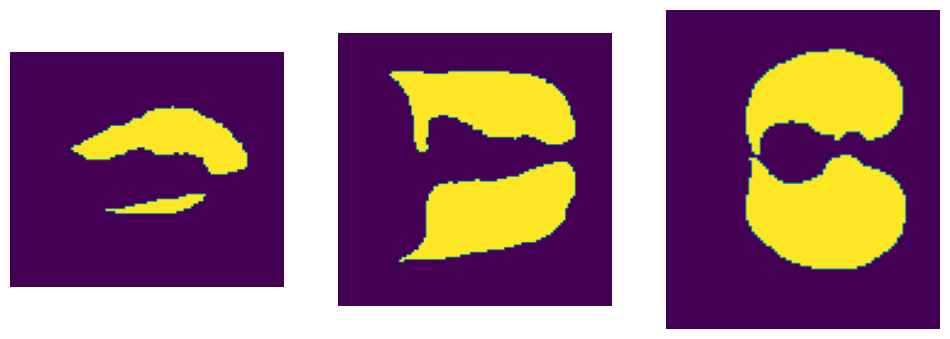

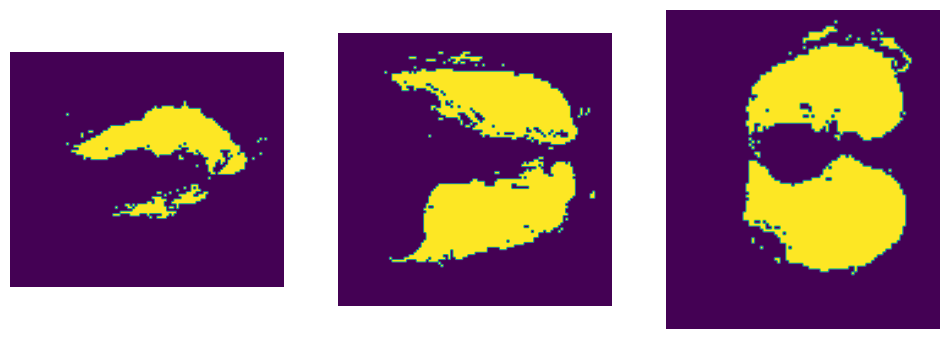

In [119]:
preview_image(moving_seg, normalize_by="slice")
preview_image(fixed_seg, normalize_by="slice")
preview_image(warped_seg, normalize_by="slice")

In [129]:
fix_lms = val_dataset_orig[9]["fixed_kp"] //2

mov_lms = val_dataset_orig[9]["moving_kp"] // 2

spacing_fix = spacing_mov = (1.5,1.5,1.5)
disp_field = flow_fields['0097'][0].cpu().numpy()

In [130]:
fix_lms.max()

96.0

In [131]:
def compute_tre(fix_lms, mov_lms, disp, spacing_fix, spacing_mov):
    
    fix_lms_disp_x = map_coordinates(disp[:, :, :, 0], fix_lms.transpose())
    fix_lms_disp_y = map_coordinates(disp[:, :, :, 1], fix_lms.transpose())
    fix_lms_disp_z = map_coordinates(disp[:, :, :, 2], fix_lms.transpose())
    fix_lms_disp = np.array((fix_lms_disp_x, fix_lms_disp_y, fix_lms_disp_z)).transpose()

    fix_lms_warped = fix_lms + fix_lms_disp
    
    
    return np.linalg.norm((fix_lms_warped - mov_lms) * spacing_mov, axis=1), fix_lms_warped

3.510833569485664


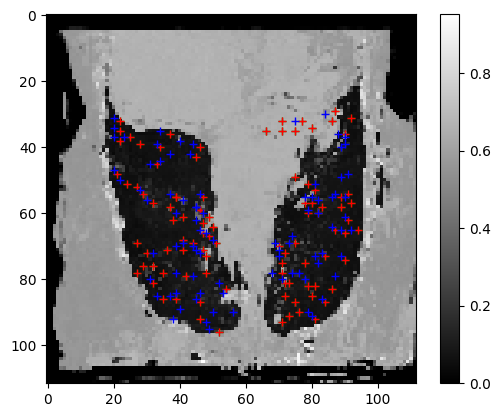

In [132]:
fix_lms = val_dataset_orig[9]["fixed_kp"] //2

mov_lms = val_dataset_orig[9]["moving_kp"] // 2

spacing_fix = spacing_mov = (1.5,1.5,1.5)
disp_field = flow_fields['0097'][0].cpu().numpy()
tre, fix_lms_warped = compute_tre(fix_lms, mov_lms, disp_field ,spacing_fix, spacing_mov)
print(tre.mean())

import matplotlib.pyplot as plt
idx=5; slice_=48

moved_img = example_warped_image.squeeze(0).squeeze(0).cpu()
H,W,D= moved_img.shape
kpts_fix_world=fix_lms_warped[abs(fix_lms_warped[:,1]-slice_)<2]
plt.imshow(moved_img[:,slice_,:].T,'gray')
plt.plot(fix_lms_[:,0], fix_lms_[:,2], 'g+')
plt.plot(kpts_fix_world[:,0], kpts_fix_world[:,2], 'r+')

plt.plot(mov_lms_[:,0], mov_lms_[:,2], 'b+')
plt.colorbar()
plt.show()

# import matplotlib.pyplot as plt
# idx=5; slice_=48

# moving_img = val_dataset[9]["moving_img"].squeeze(0).cpu()
# H,W,D= moved_img.shape
# mov_lms_=mov_lms[abs(mov_lms[:,1]-slice_)<2]
# plt.imshow(moving_img[:,slice_,:].T,'gray')
# plt.plot(mov_lms_[:,0], mov_lms_[:,2], 'r+')
# plt.colorbar()
# plt.show()

# fixed_img = val_dataset[9]["fixed_img"].squeeze(0).cpu()
# H,W,D= fixed_img.shape
# fix_lms_=fix_lms[abs(fix_lms[:,1]-slice_)<2]
# plt.imshow(moving_img[:,slice_,:].T,'gray')
# plt.plot(fix_lms_[:,0], fix_lms_[:,2], 'r+')
# plt.colorbar()
# plt.show()

In [100]:
mov_lms[0]

array([15., 57., 24.])

In [133]:
import pandas as pd
df_masks = pd.DataFrame(fix_lms_warped, columns = ['x','y','z'])


In [101]:
fix_lms[0]

array([16., 58., 25.])

In [102]:
fix_lms_warped[0]

array([16., 58., 25.])

## No masks

In [103]:
start_channel = 14
range_flow = 0.4
model_path = "/home/varsha/code/LapIRN/full/model_nomask_lncc_09.07_1/Stage/LDR_NLST_NCC_unit_disp_add_reg_1_stagelvl3_40000.pth"

orig_imgshape = (224, 192, 224)
imgshape = (224//2, 192//2, 224//2)
imgshape_4 = (imgshape[0]//4, imgshape[1]//4, imgshape[2]//4)
imgshape_2 = (imgshape[0]//2, imgshape[1]//2, imgshape[2]//2)

model_lvl1 = Miccai2020_LDR_laplacian_unit_disp_add_lvl1(2, 3, start_channel, is_train=True, imgshape=imgshape_4,
                                           range_flow=range_flow).cuda()
model_lvl2 = Miccai2020_LDR_laplacian_unit_disp_add_lvl2(2, 3, start_channel, is_train=True, imgshape=imgshape_2,
                                      range_flow=range_flow, model_lvl1=model_lvl1).cuda()

model = Miccai2020_LDR_laplacian_unit_disp_add_lvl3(2, 3, start_channel, is_train=False, imgshape=imgshape,
                                      range_flow=range_flow, model_lvl2=model_lvl2).cuda()

transform = SpatialTransform_unit().cuda()

model.load_state_dict(torch.load(model_path))
model.eval()
transform.eval()

grid = generate_grid_unit(orig_imgshape)
grid = torch.from_numpy(np.reshape(grid, (1,) + grid.shape)).cuda().float()


In [104]:
flow_fields = {}

with torch.no_grad():
    for batch_idx, batch in enumerate(val_dataloader):
        print(batch["fixed_name"][0])
        val1 = batch["fixed_name"][0][-16:-12]
        val2 = batch["moving_name"][0][-16:-12]
        input_fixed = batch["fixed_img"].to(device)

        input_moving = batch["moving_img"].to(device)

        fixed_affine = batch["fixed_affine"][0]
        print(input_moving.shape)
        F_X_Y = model(input_moving.to(device), input_fixed.to(device))
        print(F_X_Y.shape)
#         F_X_Y = F.interpolate(F_X_Y, size=orig_imgshape, mode='trilinear', align_corners=True)
        # F_X_Y = F.interpolate(F_X_Y, scale_factor=2, mode='trilinear', align_corners=True) #1. upsample
        # print(F_X_Y.shape)

        # X = F.interpolate(input_moving,scale_factor=2, mode='trilinear')
        # print(X.shape)
        # print(grid.shape)
#         X_Y = transform(input_moving, F_X_Y.permute(0, 2, 3, 4, 1), grid).data.cpu().numpy()[0, 0, :, :, :] #warped img

        #2. unnorm and flip
        F_X_Y_xyz = torch.zeros(F_X_Y.shape, dtype=F_X_Y.dtype, device=F_X_Y.device)
        _, _, x, y, z = F_X_Y.shape
        F_X_Y_xyz[0, 0] = F_X_Y[0, 2] * (x - 1) / 2
        F_X_Y_xyz[0, 1] = F_X_Y[0, 1] * (y - 1) / 2
        F_X_Y_xyz[0, 2] = F_X_Y[0, 0] * (z - 1) / 2

        # F_X_Y_clone = F_X_Y.clone()

        

#         F_X_Y_cpu = F_X_Y_xyz.data.cpu().numpy()[0, :, :, :, :].transpose(1, 2, 3, 0)
        flow_fields[val1] = F_X_Y_xyz
        print(F_X_Y_xyz.shape)   

./imagesTr/NLST_0007_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0017_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0027_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0037_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0047_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0057_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0067_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
torch.Size([1, 3, 112, 96, 112])
./imagesTr/NLST_0077_0000.nii.gz
torch.Size([1, 1, 112, 96, 112])
torch.Size

moving image:


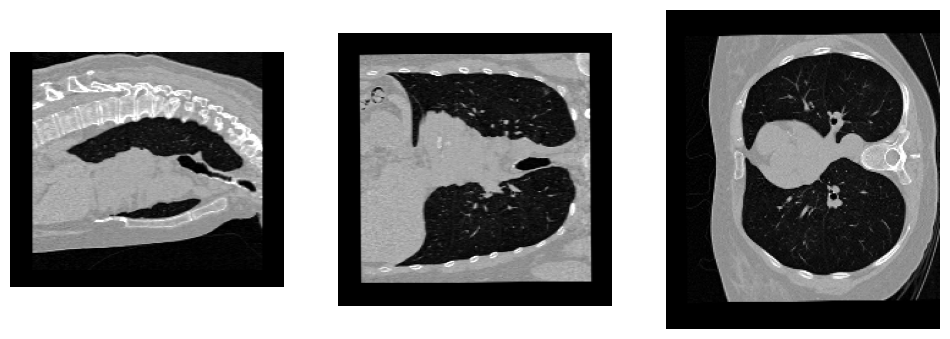

target image:


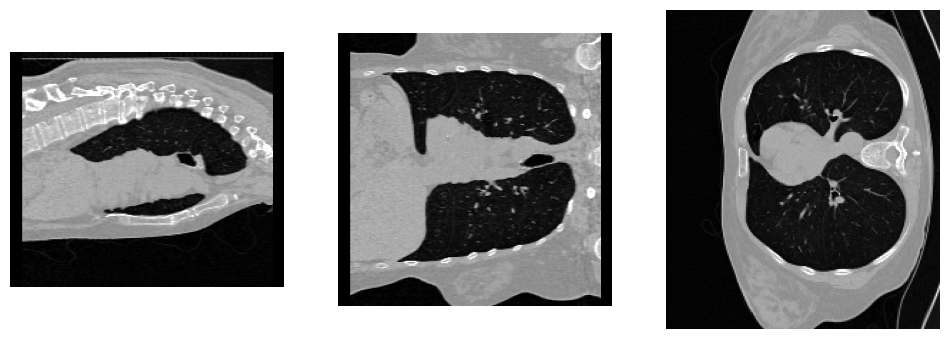

warped moving image:


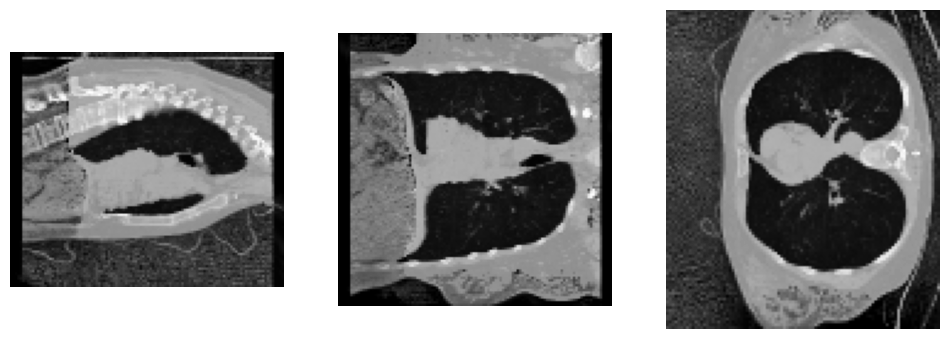

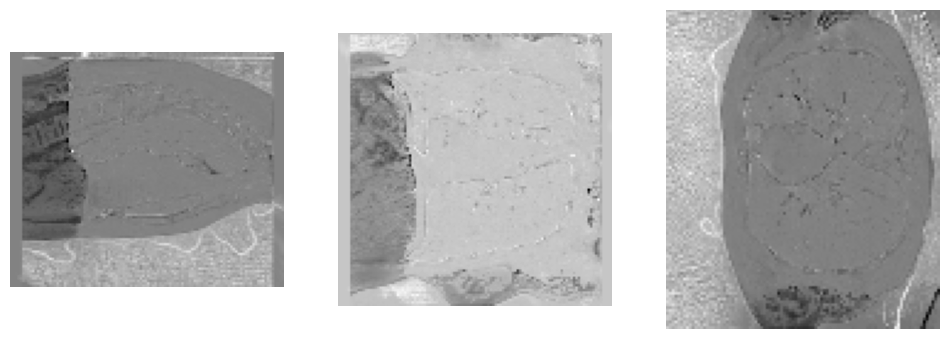

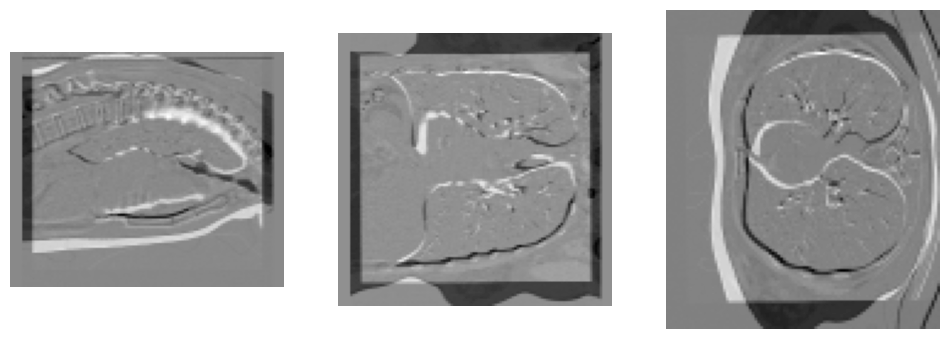

deformation vector field, projected into viewing planes:


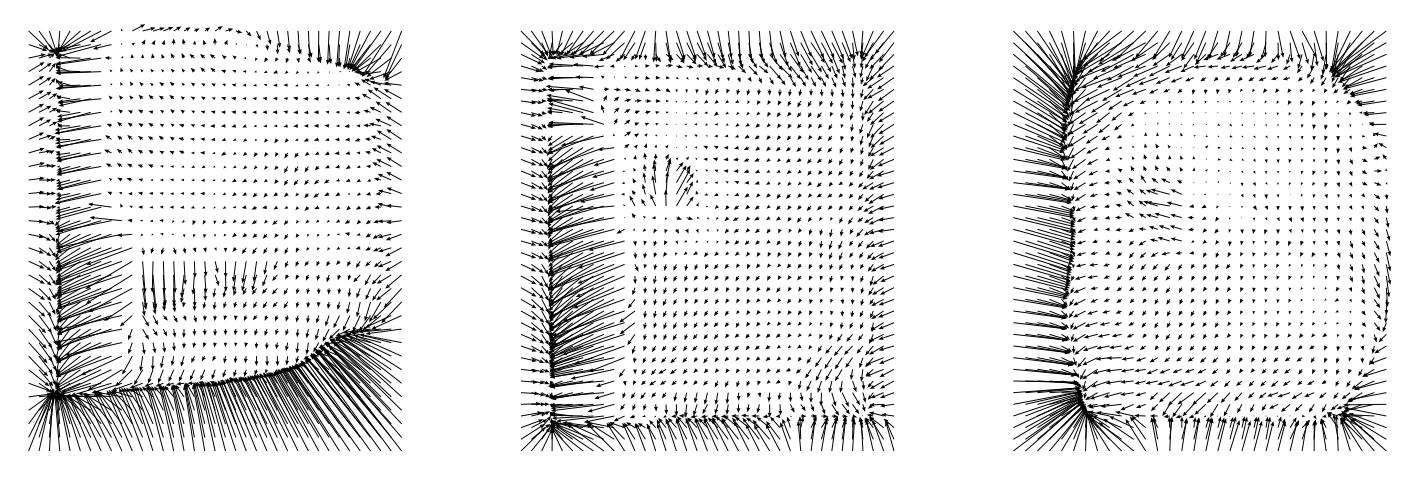

deformation applied to a grid, projected into viewing planes:


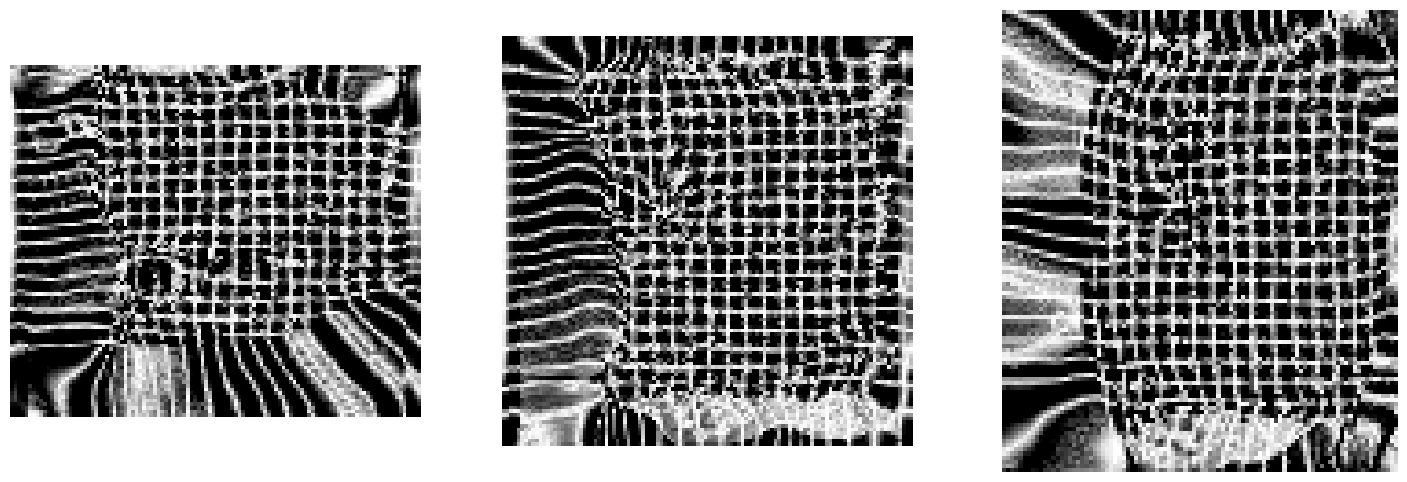

jacobian determinant:


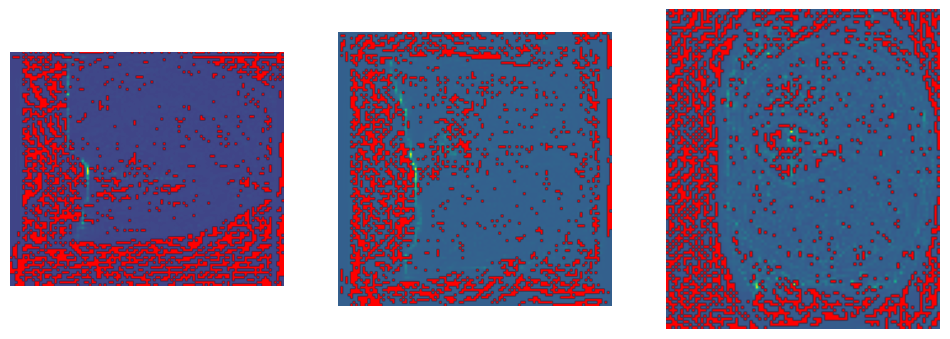

Similarity loss: -0.7444398999214172
number of folds: 349773


In [105]:
example_warped_image = warp(val_dataset[9]["moving_img"].unsqueeze(0).cuda(), flow_fields['0097'])  # moving image  # warping

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(val_dataset_orig[9]["moving_img"][0], normalize_by="slice", cmap="gray")
print("target image:")
preview_image(val_dataset_orig[9]["fixed_img"][0], normalize_by="slice", cmap="gray")
print("warped moving image:")
preview_image(example_warped_image[0, 0].cpu(), normalize_by="slice", cmap="gray")

preview_image(example_warped_image[0, 0].cpu() - val_dataset[9]["fixed_img"].unsqueeze(0)[0, 0], normalize_by="slice", cmap="gray")

preview_image(val_dataset[9]["moving_img"].unsqueeze(0)[0, 0] - val_dataset[9]["fixed_img"].unsqueeze(0)[0, 0], normalize_by="slice", cmap="gray")


print("deformation vector field, projected into viewing planes:")
preview_3D_vector_field( flow_fields['0097'].cpu().detach()[0])
print("deformation applied to a grid, projected into viewing planes:")
preview_3D_deformation( flow_fields['0097'].cpu().detach()[0], 5, linewidth=1, color="darkblue")
print("jacobian determinant:")
det = jacobian_determinant( flow_fields['0097'].cpu().detach()[0])
preview_image(det, normalize_by="slice", threshold=0)
loss = lncc_loss(example_warped_image.cpu(), val_dataset[9]["fixed_img"].unsqueeze(0)).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

(0.9764607, [tensor(0.9765)])


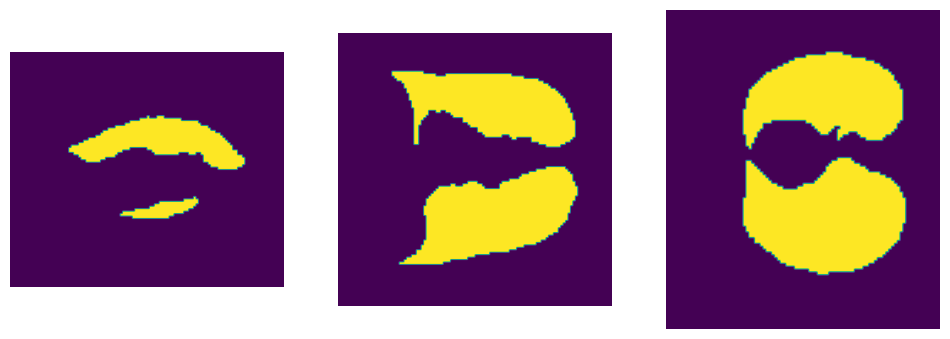

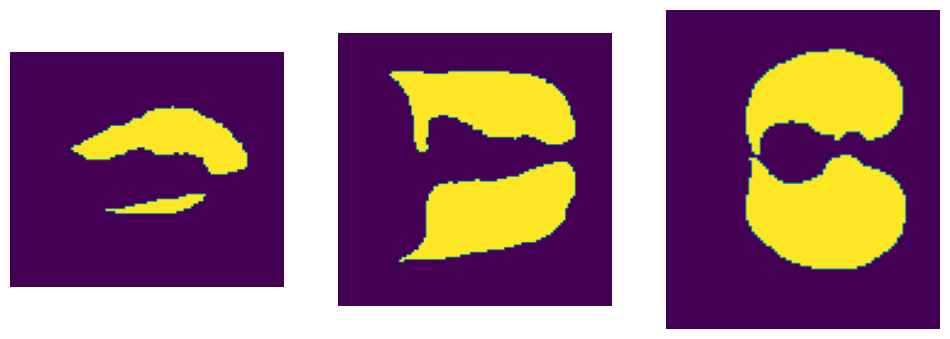

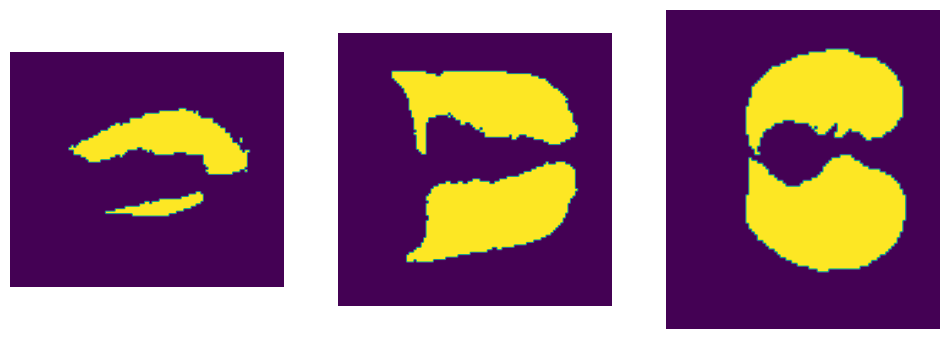

In [106]:
fixed_seg = val_dataset[9]["fixed_mask"][0]

moving_seg = val_dataset[9]["moving_mask"][0]

D,H,W = fixed_seg.shape
identity = np.meshgrid(np.arange(D), np.arange(H), np.arange(W), indexing='ij')
disp_field = flow_fields['0097'][0].permute(1,2,3,0).cpu().numpy()

labels = [1]
warped_seg = map_coordinates(moving_seg.squeeze(0).cpu(), identity + disp_field.transpose(3,0,1,2), order=0)

dice = compute_dice(fixed_seg,moving_seg,warped_seg,labels)
print(dice)

preview_image(moving_seg, normalize_by="slice")
preview_image(fixed_seg, normalize_by="slice")
preview_image(warped_seg, normalize_by="slice")

3.510833569485664


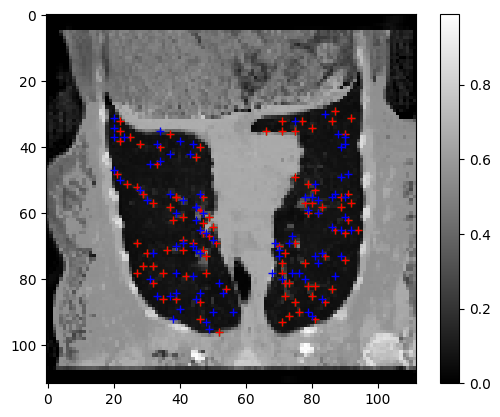

In [107]:
fix_lms = val_dataset[9]["fixed_kp"] //2

mov_lms = val_dataset[9]["moving_kp"] // 2

spacing_fix = spacing_mov = (1.5,1.5,1.5)
disp_field = flow_fields['0097'][0].cpu().numpy()
tre, fix_lms_warped = compute_tre(fix_lms, mov_lms, disp_field ,spacing_fix, spacing_mov)
print(tre.mean())

import matplotlib.pyplot as plt
idx=5; slice_=48

moved_img = example_warped_image.squeeze(0).squeeze(0).cpu()
H,W,D= moved_img.shape
kpts_fix_world=fix_lms_warped[abs(fix_lms_warped[:,1]-slice_)<2]
plt.imshow(moved_img[:,slice_,:].T,'gray')
plt.plot(fix_lms_[:,0], fix_lms_[:,2], 'g+')
plt.plot(kpts_fix_world[:,0], kpts_fix_world[:,2], 'r+')

plt.plot(mov_lms_[:,0], mov_lms_[:,2], 'b+')
plt.colorbar()
plt.show()

In [108]:
mov_lms[0]

array([15., 57., 24.])

In [109]:
fix_lms_warped[0]

array([16., 58., 25.])

In [110]:
fix_lms[0]

array([16., 58., 25.])

In [125]:
import pandas as pd
df = pd.DataFrame(fix_lms_warped, columns = ['x','y','z'])


In [138]:
(df - df_masks).describe()

x       y       z
count  1520.0  1520.0  1520.0
mean      0.0     0.0     0.0
std       0.0     0.0     0.0
min       0.0     0.0     0.0
25%       0.0     0.0     0.0
50%       0.0     0.0     0.0
75%       0.0     0.0     0.0
max       0.0     0.0     0.0